0.92
ECE: 6.550000000000005
0.6589673913043478
100


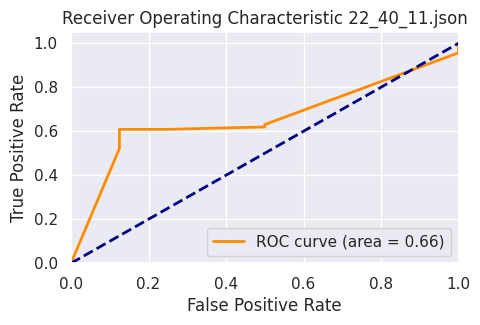

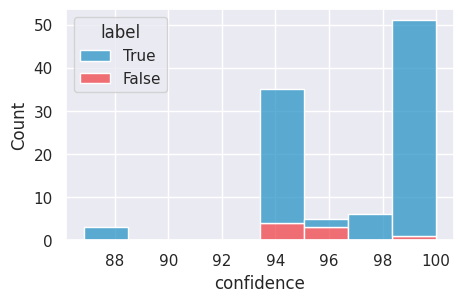

In [11]:
import json
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

sns.set_theme()

# /home/zijie/Experiments/Debate/result/GSM/2024_09_09/17_26_13.json
GSM_result_dir = "../result/GSM/2024_09_11"
GSM_result_file = "22_40_11.json"


def HisplotSeaborn(df):
    plt.figure(figsize=(5, 3), dpi=100) 
    custom_palette = ["#2993C7", "#F1444A"]
    penguins = sns.load_dataset("penguins")
    sns.histplot(data=df, x="confidence", hue="label", hue_order = [True, False], multiple="stack", palette=custom_palette)
    plt.show()


def AUC_ROC(y_true, y_score, title, output_file):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # draw the ROC curve
    plt.figure(figsize=(5, 3), dpi=100)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic ' + title)
    plt.legend(loc="lower right")
    plt.savefig(output_file)
    print(roc_auc)
    return roc_auc


def ExtractAnswerGSM(answer):
    gt_answer = answer.split("Answer: ")[1].replace(",", "")
    
    pattern = r'\d+(?:\.\d+)?'
    match = re.search(pattern, gt_answer)
    
    if match:
        return float(match.group())
    else:
        return None
    

# Extract the confidence of both assistants from the debate history
def ExtractConfidenceDual(confidence):
    confidence_lines = confidence.strip().split('\n')
    
    confidence_dict = {}
    for line in confidence_lines:
        if "assistant 1:" in line.lower():
            conf = line.lower().split("assistant 1: ")[1]
            confidence_dict["assistant_1"] = int(conf)
        elif "assistant 2:" in line.lower():
            conf = line.lower().split("assistant 2: ")[1]
            confidence_dict["assistant_2"] = int(conf)
    if len(confidence_dict) == 2:
        return confidence_dict
    return None


# Extract the confidence of the assistant from the debate history
def ExtractConfidenceSingle(confidence):
    confidence_lines = confidence.strip().split('\n')
    confidence_dict = {}
    for line in confidence_lines:
        pattern = r"assistant:\s*\d+"
        if re.search(pattern, line, re.IGNORECASE):
            conf = line.lower().split("assistant: ")[1]
            confidence_dict["assistant"] = int(conf)
    if len(confidence_dict) == 1:
        return confidence_dict
    return None


# This function is used to calculate the Expected Calibration Error (ECE) of the result
# The format of 'conf_list' is as follows:
# [{
#    "conf": <float>,
#    "label": <bool>
# },...]
def CalculateECE(conf_list):
    bin_box = {i: [] for i in range(0, 101, 1)}
    for conf in conf_list:
        conf_bin = int(conf["conf"])
        bin_box[conf_bin].append(1 if conf["label"] == True else 0)
    
    ece_score = 0
    for b, labels in bin_box.items():
        if len(labels) == 0:
            continue
        ece_score += (len(labels) / len(conf_list)) * abs(100 * (sum(labels) / len(labels)) - b) 
    print("ECE:", ece_score)
    return ece_score
    


def AnalysisGSMDual():
    path = os.path.join("./result/GSM", "Analysis")
    os.makedirs(path, exist_ok=True)
    
    with open(os.path.join(GSM_result_dir, GSM_result_file), "r") as file:
        data = json.load(file)
        
    res = []
    for debate in data:
        ground_truth = float(debate["ground_truth"].replace(",", ""))
        r_1 = ExtractAnswerGSM(debate["response_1"])
        r_2 = ExtractAnswerGSM(debate["response_2"])
        
        debate_status = {
            "question": debate["question"],
            "ground_truth": ground_truth,
            "response_1": r_1,
            "response_2": r_2,
            "a1_correct": r_1 == ground_truth,
            "a2_correct": r_2 == ground_truth
        }
        
        round_cnt = 0
        conf_1_list, conf_2_list = [], []
        for his in debate["chat_history"]:
            conf = ExtractConfidenceDual(his["response"])
            if conf is None:
                continue
            else:
                round_cnt += 1
                conf_1_list.append(conf["assistant_1"])
                conf_2_list.append(conf["assistant_2"])

        debate_status["conf_1_ave"] = conf_1_ave = sum(conf_1_list) / round_cnt
        debate_status["conf_2_ave"] = conf_2_ave = sum(conf_2_list) / round_cnt
        debate_status["answer_voted"] = r_1 if conf_1_ave > conf_2_ave else r_2
        debate_status["answer_voted_conf"] = conf_1_ave if conf_1_ave > conf_2_ave else conf_2_ave
        debate_status["answer_voted_correct"] = debate_status["answer_voted"] == ground_truth and debate_status["answer_voted_conf"] > 0.95
        
        res.append(debate_status)
        
    
    a1_correct_ratio = sum([1 for r in res if r["a1_correct"]]) / len(res)
    a2_correct_ratio = sum([1 for r in res if r["a2_correct"]]) / len(res)
    voted_correct = sum([1 for r in res if r["answer_voted_correct"]]) / len(res)
    print(a1_correct_ratio, a2_correct_ratio, voted_correct)
        
    
    asst_1_conf_list = [{"conf": r["conf_1_ave"], "label": r["a1_correct"]} for r in res]
    asst_2_conf_list = [{"conf": r["conf_2_ave"], "label": r["a2_correct"]} for r in res]
    answer_voted_conf_list = [{"conf": r["answer_voted_conf"], "label": r["answer_voted_correct"]} for r in res]
    CalculateECE(asst_1_conf_list)
    CalculateECE(asst_2_conf_list)
    CalculateECE(answer_voted_conf_list)
    
    file_name = os.path.splitext(GSM_result_file)[0]
    with open(os.path.join(path, "GSM_analysis_" + file_name + ".json"), "w") as f:
        json.dump(res, f, indent=4)
    
    # output the AUC-ROC curve
    path_figure = os.path.join("./result/GSM", "Analysis", "Figures", GSM_result_dir.split("/")[-1])
    os.makedirs(path_figure, exist_ok=True)
    y_scores_a1 = [asst["conf"] for asst in asst_1_conf_list]
    y_true_a1 = [asst["label"] for asst in asst_1_conf_list]
    AUC_ROC(y_true_a1, y_scores_a1, GSM_result_file, os.path.join(path_figure, file_name + "_a1.png"))
    
    y_scores_a2 = [asst["conf"] for asst in asst_2_conf_list]
    y_true_a2 = [asst["label"] for asst in asst_2_conf_list]
    AUC_ROC(y_true_a2, y_scores_a2, GSM_result_file, os.path.join(path_figure, file_name + "_a2.png"))
    
    y_scores_voted = [v["conf"] for v in answer_voted_conf_list]
    y_true_voted = [v["label"] for v in answer_voted_conf_list]
    AUC_ROC(y_true_voted, y_scores_voted, GSM_result_file, os.path.join(path_figure,  file_name + "_voted.png"))
        
        
def AnalysisGSMSingle():
    path = os.path.join("./result/GSM", "Analysis", GSM_result_dir.split("/")[-1])
    os.makedirs(path, exist_ok=True)
    
    with open(os.path.join(GSM_result_dir, GSM_result_file), "r") as file:
        data = json.load(file)
        
    res = []
    for debate in data:
        ground_truth = float(debate["ground_truth"].replace(",", ""))
        r = ExtractAnswerGSM(debate["response"])
        
        debate_status = {
            "question": debate["question"],
            "ground_truth": ground_truth,
            "response": r,
            "correct": r == ground_truth,
            "assistant_model": debate["assistant_model"],
        }
        
        round_cnt = 0
        conf_list = []
        for his in debate["chat_history"]:
            conf = ExtractConfidenceSingle(his["response"])
            if conf is None:
                continue
            else:
                round_cnt += 1
                conf_list.append(conf["assistant"])

        debate_status["conf_ave"] = sum(conf_list) / round_cnt
        
        res.append(debate_status)
        
    
    correct_rate = sum([1 for r in res if r["correct"]]) / len(res)
    print(correct_rate)
        
    
    asst_conf_list = [{"conf": r["conf_ave"], "label": r["correct"]} for r in res]
    ece_score = CalculateECE(asst_conf_list)
    res.append({})
    res[-1]["ece_score"] = ece_score
    res[-1]["correct_rate"] = correct_rate
    
    
    with open(os.path.join(path, "GSM_analysis_" + os.path.splitext(GSM_result_file)[0] + ".json"), "w") as f:
        json.dump(res, f, indent=4)
        
    y_scores = [asst["conf"] for asst in asst_conf_list]
    y_true = [asst["label"] for asst in asst_conf_list]
        
    file_name = os.path.splitext(GSM_result_file)[0]
    path_figure = os.path.join("./result/GSM", "Analysis", "Figures", GSM_result_dir.split("/")[-1])
    os.makedirs(path_figure, exist_ok=True)
    AUC_ROC(y_true, y_scores, GSM_result_file, os.path.join(path_figure,  file_name + "_single.png"))

    data = {
        'confidence': y_scores,
        'label': y_true
    }
    df = pd.DataFrame(data)
    print(len(df))
    HisplotSeaborn(df)


if __name__ == "__main__":
    AnalysisGSMSingle()
    # AnalysisGSMDual()